In [41]:
import os
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [42]:
# Build a .py script that takes a snapshot date, trains a model and outputs artefact into storage.

## set up pyspark session

In [43]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

## set up config

In [94]:
# set up config
model_train_date_str = "2024-06-01"
train_test_period_months = 4
oot_period_months = 2
train_test_ratio = 0.8

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_test_ratio"] = train_test_ratio 


pprint.pprint(config)

{'model_train_date': datetime.datetime(2024, 6, 1, 0, 0),
 'model_train_date_str': '2024-06-01',
 'oot_end_date': datetime.datetime(2024, 5, 31, 0, 0),
 'oot_period_months': 2,
 'oot_start_date': datetime.datetime(2024, 4, 1, 0, 0),
 'train_test_end_date': datetime.datetime(2024, 3, 31, 0, 0),
 'train_test_period_months': 4,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.datetime(2023, 12, 1, 0, 0)}


## get label store

In [73]:
# connect to label store
folder_path = "datamart/gold/label_store/"
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
label_store_sdf = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",label_store_sdf.count())

label_store_sdf.show()

row_count: 8974
+--------------------+-----------+-----+----------+-------------+
|             loan_id|customer_id|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-0

In [74]:
# extract label store
labels_sdf = label_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

print("extracted labels_sdf", labels_sdf.count(), config["train_test_start_date"], config["oot_end_date"])

extracted labels_sdf 2901 2023-12-01 00:00:00 2024-05-31 00:00:00


## get features

In [75]:
folder_path = "datamart/gold/feature_store/"
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
features_store_sdf = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",features_store_sdf.count())

features_store_sdf.show()

[Stage 83:==============>                                          (3 + 9) / 12]

row_count: 8974
+-----------+-------------+---+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+-------------------+-----------------------+---------------+------------------------+-------------+---------+-------------------+-------------+-------------+------------+----------------+-----------+-----------------------+-----------------+--------------------+-----------------+-------------------+------------------------+-------------------+--------------------+--------------------+------------------+---------------------+-----------------------+---------------------+-------------------+-----------------+------------------+-------------------------+------------------------+------------------------+-------------------+---------------+--------------+---------------------------+----------------------------+---------------

In [76]:
# extract label store
features_sdf = features_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

print("extracted features_sdf", features_sdf.count(), config["train_test_start_date"], config["oot_end_date"])

[Stage 87:====>                                                   (1 + 11) / 12]

extracted features_sdf 3007 2023-12-01 00:00:00 2024-05-31 00:00:00


## prepare data for modeling

In [111]:
# prepare data for modeling
data_pdf = labels_sdf.join(features_store_sdf.drop('snapshot_date'), on=["customer_id"], how="left").toPandas()
data_pdf

,customer_id,loan_id,label,label_def,snapshot_date,age,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,...,avg_fe_11,avg_fe_12,avg_fe_13,avg_fe_14,avg_fe_15,avg_fe_16,avg_fe_17,avg_fe_18,avg_fe_19,avg_fe_20
0,CUS_0x1044,CUS_0x1044_2023_06_01,0,30dpd_6mob,2023-12-01,44,33441.589844,2748.799072,2.0,4.0,...,109.500000,28.000000,91.333333,126.666667,101.333333,14.666667,152.166667,139.000000,108.833333,82.166667
1,CUS_0x104e,CUS_0x104e_2023_06_01,0,30dpd_6mob,2023-12-01,50,19180.869141,1688.405884,8.0,4.0,...,97.166667,85.000000,22.000000,109.333333,62.166667,108.333333,168.666667,133.166667,79.833333,93.500000
2,CUS_0x105c,CUS_0x105c_2023_06_01,0,30dpd_6mob,2023-12-01,33,127617.601562,10596.799805,0.0,4.0,...,29.666667,125.333333,93.333333,148.333333,101.666667,114.333333,60.166667,55.500000,152.833333,98.500000
3,CUS_0x10ee,CUS_0x10ee_2023_06_01,1,30dpd_6mob,2023-12-01,30,12660.160156,909.013306,5.0,7.0,...,69.500000,37.333333,61.000000,66.500000,104.666667,74.000000,102.833333,108.666667,102.000000,138.333333
4,CUS_0x1136,CUS_0x1136_2023_06_01,1,30dpd_6mob,2023-12-01,22,37360.941406,2864.411621,10.0,5.0,...,82.833333,78.666667,149.000000,68.333333,68.833333,68.333333,137.000000,143.833333,110.000000,77.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896,CUS_0xdf6,CUS_0xdf6_2023_09_01,0,30dpd_6mob,2024-03-01,55,40453.851562,2772.811035,2.0,2.0,...,146.666667,175.444444,103.111111,111.222222,50.444444,98.444444,36.111111,144.333333,100.777778,119.777778
2897,CUS_0xe23,CUS_0xe23_2023_09_01,0,30dpd_6mob,2024-03-01,39,17815.585938,1427.632080,8.0,6.0,...,57.444444,117.888889,143.666667,76.222222,158.555556,86.666667,70.777778,90.333333,85.000000,33.111111
2898,CUS_0xe4e,CUS_0xe4e_2023_09_01,0,30dpd_6mob,2024-03-01,22,108073.679688,8738.139648,3.0,3.0,...,144.444444,87.888889,104.888889,126.333333,111.666667,196.000000,116.666667,81.333333,108.222222,52.888889
2899,CUS_0xedd,CUS_0xedd_2023_09_01,0,30dpd_6mob,2024-03-01,33,125468.437500,10445.703125,4.0,4.0,...,93.777778,85.000000,92.111111,126.777778,156.555556,103.000000,50.888889,79.888889,134.777778,77.111111


In [79]:
data_pdf.columns.tolist()

['customer_id',
 'loan_id',
 'label',
 'label_def',
 'snapshot_date',
 'age',
 'annual_income',
 'monthly_inhand_salary',
 'num_bank_accounts',
 'num_credit_card',
 'interest_rate',
 'num_of_loan',
 'delay_from_due_date',
 'num_of_delayed_payment',
 'changed_credit_limit',
 'num_credit_inquiries',
 'outstanding_debt',
 'credit_utilization_ratio',
 'total_emi_per_month',
 'amount_invested_monthly',
 'monthly_balance',
 'credit_history_age_month',
 'mortgage_loan',
 'auto_loan',
 'credit-builder_loan',
 'personal_loan',
 'not_specified',
 'student_loan',
 'home_equity_loan',
 'payday_loan',
 'debt_consolidation_loan',
 'occupation_lawyer',
 'occupation_architect',
 'occupation_doctor',
 'occupation_mechanic',
 'occupation_media_manager',
 'occupation_engineer',
 'occupation_developer',
 'occupation_scientist',
 'occupation_teacher',
 'occupation_accountant',
 'occupation_entrepreneur',
 'occupation_journalist',
 'occupation_musician',
 'occupation_writer',
 'occupation_manager',
 'paymen

In [80]:
# split data into train - test - oot
oot_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["oot_start_date"].date()) & (data_pdf['snapshot_date'] <= config["oot_end_date"].date())]
train_test_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["train_test_start_date"].date()) & (data_pdf['snapshot_date'] <= config["train_test_end_date"].date())]

# feature_cols = [fe_col for fe_col in data_pdf.columns if fe_col.startswith('fe_')]
feature_cols = data_pdf.columns.tolist()[5:]


X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["label"]
X_train, X_test, y_train, y_test = train_test_split(
    train_test_pdf[feature_cols], train_test_pdf["label"], 
    test_size= 1 - config["train_test_ratio"],
    random_state=88,     # Ensures reproducibility
    shuffle=True,        # Shuffle the data before splitting
    stratify=train_test_pdf["label"]           # Stratify based on the label column
)


print('X_train', X_train.shape[0])
print('X_test', X_test.shape[0])
print('X_oot', X_oot.shape[0])
print('y_train', y_train.shape[0], round(y_train.mean(),2))
print('y_test', y_test.shape[0], round(y_test.mean(),2))
print('y_oot', y_oot.shape[0], round(y_oot.mean(),2))

X_train

X_train 1538
X_test 385
X_oot 978
y_train 1538 0.28
y_test 385 0.28
y_oot 978 0.27


,age,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,...,avg_fe_11,avg_fe_12,avg_fe_13,avg_fe_14,avg_fe_15,avg_fe_16,avg_fe_17,avg_fe_18,avg_fe_19,avg_fe_20
1253,45,10455.584961,727.298767,10.0,9.0,30.0,3.0,32,20.0,6.520000,...,84.000000,195.250000,115.500000,96.875000,103.375000,81.250000,115.000000,143.875000,102.500000,98.250000
1121,26,104616.898438,8481.075195,7.0,6.0,14.0,4.0,19,12.0,1.590000,...,70.375000,96.625000,145.375000,49.750000,125.125000,22.375000,94.375000,45.000000,105.500000,102.625000
474,45,42947.488281,3470.957520,4.0,7.0,15.0,2.0,15,20.0,18.379999,...,119.500000,94.833333,111.000000,93.666667,151.500000,43.000000,195.500000,165.333333,107.500000,85.166667
126,21,18314.570312,1421.214111,6.0,7.0,18.0,2.0,19,9.0,9.570000,...,98.333333,74.111111,109.333333,58.444444,52.555556,141.666667,70.333333,73.666667,74.111111,78.555556
129,38,15590.679688,1298.223389,7.0,9.0,26.0,9.0,47,16.0,28.980000,...,68.111111,47.777778,83.555556,60.333333,126.444444,103.111111,116.111111,155.111111,80.222222,167.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,45,41550.058594,3000.938965,9.0,7.0,24.0,2.0,44,19.0,8.280000,...,109.833333,113.500000,47.666667,-27.833333,117.833333,130.333333,79.833333,10.500000,93.166667,116.333333
210,31,31517.470703,2484.455811,7.0,3.0,5.0,4.0,23,6.0,8.970000,...,66.833333,48.666667,97.500000,95.166667,177.833333,127.000000,98.500000,110.000000,69.666667,97.833333
149,49,16199.955078,1140.996216,3.0,7.0,7.0,4.0,1,11.0,4.880000,...,142.888889,62.666667,121.555556,103.444444,114.555556,119.555556,119.666667,102.000000,116.000000,84.777778
2745,27,15503.019531,1250.285400,6.0,7.0,30.0,6.0,42,23.0,6.220000,...,147.500000,78.500000,100.500000,97.625000,67.250000,112.000000,100.500000,133.125000,99.875000,98.250000


## preprocess data

In [81]:
# set up standard scalar preprocessing
scaler = StandardScaler()

transformer_stdscaler = scaler.fit(X_train) # Q which should we use? train? test? oot? all?

# transform data
X_train_processed = transformer_stdscaler.transform(X_train)
X_test_processed = transformer_stdscaler.transform(X_test)
X_oot_processed = transformer_stdscaler.transform(X_oot)

print('X_train_processed', X_train_processed.shape[0])
print('X_test_processed', X_test_processed.shape[0])
print('X_oot_processed', X_oot_processed.shape[0])

pd.DataFrame(X_train_processed)

X_train_processed 1538
X_test_processed 385
X_oot_processed 978


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1.039377,-0.128075,-1.086826,1.746502,1.600589,1.704853,-0.242492,0.772693,1.079489,-0.562819,...,-0.428306,2.692913,0.396401,-0.058344,0.078537,-0.519656,0.406150,1.131334,0.034993,-0.069607
1,-0.730696,-0.070709,1.356339,0.622132,0.190408,-0.080002,0.182125,-0.133686,-0.232204,-1.282335,...,-0.796316,-0.065155,1.216583,-1.322023,0.663645,-2.055618,-0.152186,-1.431913,0.112952,0.045279
2,1.039377,-0.108280,-0.222317,-0.502238,0.660468,0.031551,-0.667109,-0.412571,1.079489,1.168105,...,0.530547,-0.115259,0.272859,-0.144377,1.373172,-1.517542,2.585351,1.687623,0.164924,-0.413173
3,-1.196504,-0.123287,-0.868178,0.247342,0.660468,0.366212,-0.667109,-0.133686,-0.724089,-0.117683,...,-0.041163,-0.694760,0.227103,-1.088878,-1.288583,1.056526,-0.803014,-0.688755,-0.702730,-0.586779
4,0.387245,-0.124946,-0.906932,0.622132,1.600589,1.258639,2.305207,1.818515,0.423642,2.715137,...,-0.857464,-1.431177,-0.480595,-1.038226,0.699140,0.050669,0.436228,1.422621,-0.543925,1.744505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533,1.039377,-0.109131,-0.370417,1.371712,0.660468,1.035532,-0.667109,1.609351,0.915527,-0.305953,...,0.269451,0.406758,-1.465880,-3.402457,0.467488,0.760856,-0.545841,-2.326296,-0.207546,0.405257
1534,-0.264887,-0.115243,-0.533157,0.622132,-1.219773,-1.083983,0.182125,0.145200,-1.215974,-0.205250,...,-0.891976,-1.406319,-0.097767,-0.104154,2.081579,0.673895,-0.040519,0.253155,-0.818225,-0.080549
1535,1.412024,-0.124575,-0.956473,-0.877028,0.660468,-0.860876,0.182125,-1.388672,-0.396166,-0.802171,...,1.162280,-1.014806,0.562649,0.117818,0.379311,0.479680,0.532480,0.045762,0.385808,-0.423385
1536,-0.637534,-0.125000,-0.922036,0.247342,0.660468,1.704853,1.031358,1.469908,1.571374,-0.606603,...,1.286826,-0.572024,-0.015406,-0.038233,-0.893280,0.282567,0.013623,0.852650,-0.033221,-0.069607


## train model

#### XGBoost

In [82]:
# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=88)

# Define the hyperparameter space to search
param_dist = {
    'n_estimators': [25, 50],
    'max_depth': [2, 3],  # lower max_depth to simplify the model
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Create a scorer based on AUC score
auc_scorer = make_scorer(roc_auc_score)

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    scoring=auc_scorer,
    n_iter=100,  # Number of iterations for random search
    cv=3,       # Number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the random search
random_search.fit(X_train_processed, y_train)

# Output the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best AUC score: ", random_search.best_score_)

# Evaluate the model on the train set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_train_processed)[:, 1]
train_auc_score = roc_auc_score(y_train, y_pred_proba)
print("Train AUC score: ", train_auc_score)

# Evaluate the model on the test set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]
test_auc_score = roc_auc_score(y_test, y_pred_proba)
print("Test AUC score: ", test_auc_score)

# Evaluate the model on the oot set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_oot_processed)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

print("TRAIN GINI score: ", round(2*train_auc_score-1,3))
print("Test GINI score: ", round(2*test_auc_score-1,3))
print("OOT GINI score: ", round(2*oot_auc_score-1,3))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best AUC score:  0.7559499566541822
Train AUC score:  0.9516944514608064
Test AUC score:  0.872150877428898
OOT AUC score:  0.9015030481395838
TRAIN GINI score:  0.903
Test GINI score:  0.744
OOT GINI score:  0.803


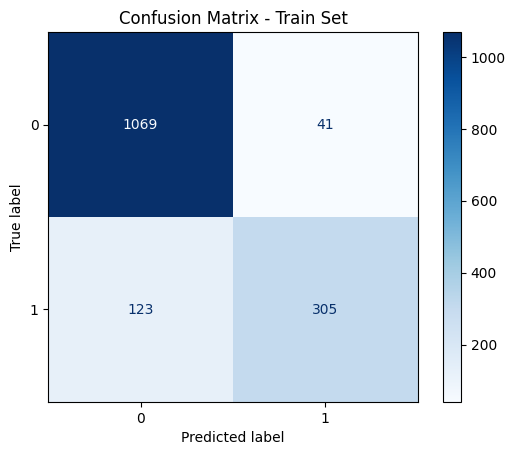

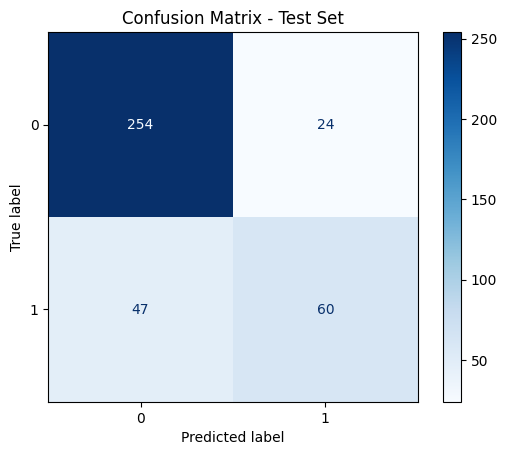

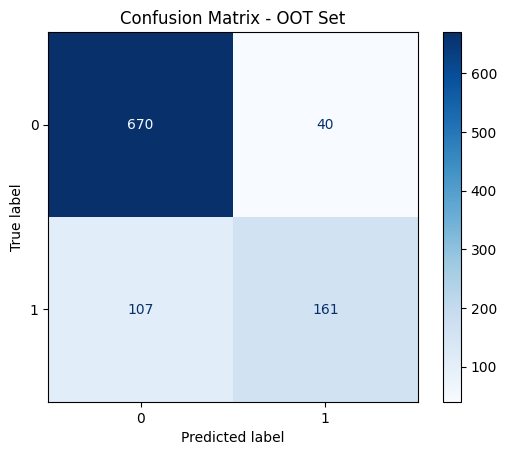

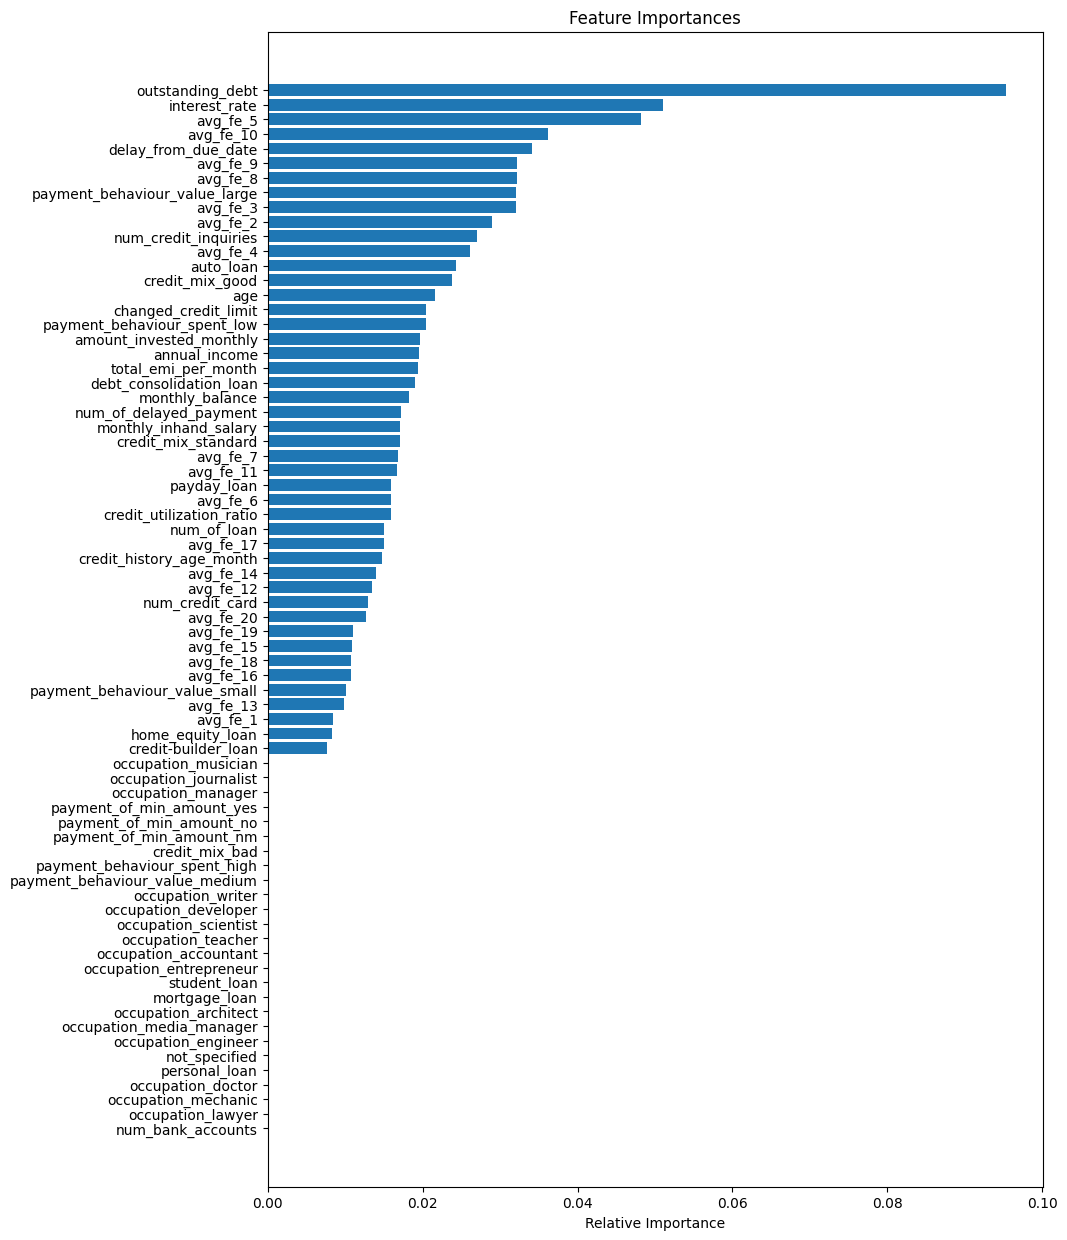

In [107]:
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# --- Confusion Matrix ---
# Predict binary labels for confusion matrix
y_pred_train = best_model.predict(X_train_processed)
y_pred_test = best_model.predict(X_test_processed)
y_pred_oot = best_model.predict(X_oot_processed)

# Train confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0, 1])
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Train Set")
plt.show()

# Test confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

# OOT confusion matrix
cm_oot = confusion_matrix(y_oot, y_pred_oot)
disp_oot = ConfusionMatrixDisplay(confusion_matrix=cm_oot, display_labels=[0, 1])
disp_oot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - OOT Set")
plt.show()

# --- Feature Importance ---
# Feature importance plot
importances = best_model.feature_importances_

# Sort feature importance in descending order
indices = np.argsort(importances)[::-1]
features = feature_cols

# Plot the feature importance
plt.figure(figsize=(10, 15))
plt.title("Feature Importances")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

### Logsitic Regression

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

# Define the Logistic Regression classifier
log_reg_clf = LogisticRegression(solver='liblinear', random_state=88)

# Define the hyperparameter space to search
param_dist = {
    'C': [0.01, 0.1, 1, 10],          # Regularization strength
    'penalty': ['l1', 'l2'],           # Type of regularization
    'max_iter': [100, 200, 300],       # Maximum number of iterations for convergence
    'solver': ['liblinear'],           # Solver to use for optimization
}

# Create a scorer based on AUC score
auc_scorer = make_scorer(roc_auc_score)

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=log_reg_clf,
    param_distributions=param_dist,
    scoring=auc_scorer,
    n_iter=100,  # Number of iterations for random search
    cv=3,        # Number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1     # Use all available cores
)

# Perform the random search
random_search.fit(X_train_processed, y_train)

# Output the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best AUC score: ", random_search.best_score_)

# Evaluate the model on the train set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_train_processed)[:, 1]
train_auc_score = roc_auc_score(y_train, y_pred_proba)
print("Train AUC score: ", train_auc_score)

# Evaluate the model on the test set
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]
test_auc_score = roc_auc_score(y_test, y_pred_proba)
print("Test AUC score: ", test_auc_score)

# Evaluate the model on the oot set
y_pred_proba = best_model.predict_proba(X_oot_processed)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

# Calculate Gini score
print("TRAIN GINI score: ", round(2 * train_auc_score - 1, 3))
print("Test GINI score: ", round(2 * test_auc_score - 1, 3))
print("OOT GINI score: ", round(2 * oot_auc_score - 1, 3))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 0.01}
Best AUC score:  0.7782818374367669
Train AUC score:  0.8992274985265639
Test AUC score:  0.8838835473677134
OOT AUC score:  0.875268026066849
TRAIN GINI score:  0.798
Test GINI score:  0.768
OOT GINI score:  0.751


## prepare model artefact to save

In [90]:
model_artefact = {}

model_artefact['model'] = best_model
model_artefact['model_version'] = "credit_model_"+config["model_train_date_str"].replace('-','_')
model_artefact['preprocessing_transformers'] = {}
model_artefact['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact['data_dates'] = config
model_artefact['data_stats'] = {}
model_artefact['data_stats']['X_train'] = X_train.shape[0]
model_artefact['data_stats']['X_test'] = X_test.shape[0]
model_artefact['data_stats']['X_oot'] = X_oot.shape[0]
model_artefact['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact['data_stats']['y_oot'] = round(y_oot.mean(),2)
model_artefact['results'] = {}
model_artefact['results']['auc_train'] = train_auc_score
model_artefact['results']['auc_test'] = test_auc_score
model_artefact['results']['auc_oot'] = oot_auc_score
model_artefact['results']['gini_train'] = round(2*train_auc_score-1,3)
model_artefact['results']['gini_test'] = round(2*test_auc_score-1,3)
model_artefact['results']['gini_oot'] = round(2*oot_auc_score-1,3)
model_artefact['hp_params'] = random_search.best_params_


pprint.pprint(model_artefact)

{'data_dates': {'model_train_date': datetime.datetime(2024, 6, 1, 0, 0),
                'model_train_date_str': '2024-06-01',
                'oot_end_date': datetime.datetime(2024, 5, 31, 0, 0),
                'oot_period_months': 2,
                'oot_start_date': datetime.datetime(2024, 4, 1, 0, 0),
                'train_test_end_date': datetime.datetime(2024, 3, 31, 0, 0),
                'train_test_period_months': 4,
                'train_test_ratio': 0.8,
                'train_test_start_date': datetime.datetime(2023, 12, 1, 0, 0)},
 'data_stats': {'X_oot': 978,
                'X_test': 385,
                'X_train': 1538,
                'y_oot': np.float64(0.27),
                'y_test': np.float64(0.28),
                'y_train': np.float64(0.28)},
 'hp_params': {'colsample_bytree': 0.8,
               'gamma': 0,
               'learning_rate': 0.1,
               'max_depth': 3,
               'min_child_weight': 1,
               'n_estimators': 50,
            

## save artefact to model bank

In [91]:
# create model_bank dir
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

In [92]:
# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Model saved to {file_path}")


Model saved to model_bank/credit_model_2024_06_01.pkl


## test load pickle and make model inference

In [65]:
# Load the model from the pickle file
with open(file_path, 'rb') as file:
    loaded_model_artefact = pickle.load(file)

y_pred_proba = loaded_model_artefact['model'].predict_proba(X_oot_processed)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

print("Model loaded successfully!")

OOT AUC score:  0.9194611761071857
Model loaded successfully!
